# Spark SQL

Before you begin, make sure that you've installed spark of version `2.3` or higher (see `README.md`)

**Links**

* https://spark.apache.org/docs/latest/sql-getting-started.html

In [1]:
!pwd && ls -lah | grep README

/home/maria/MLBD/spark_sql/notebooks
-rw-rw-r-- 1 maria maria 1.2K Feb  2 19:00 README.md


## Запуск spark

In [2]:
import numpy as np
import os

os.environ['JAVA_HOME']

'/usr/lib/jvm/java-8-openjdk-amd64/jre'

In [3]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession


spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("spark_sql_examples") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "30g") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [4]:
DATA_PATH = '/home/maria/MLBD/data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

---
## DataFrame creation

DataFrame можно создать несколькими способами:

* из файла
* из существующего RDD
* из другого DataFrame'a

### From file

В случае с созданием из csv файла, может понадобится указать схему

In [5]:
from pyspark.sql.types import *


schema = StructType([
    StructField('user_id', IntegerType()),
    StructField('movie_id', IntegerType()),
    StructField('rating', FloatType()),
    StructField('timestamp', IntegerType())
])

ratings_df = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .schema(schema) \
    .options(header='true', delimiter=',') \
    .load('file:///' + RATINGS_PATH)

In [6]:
ratings_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- movie_id: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- timestamp: integer (nullable = true)



In [7]:
ratings_df.take(5)

[Row(user_id=1, movie_id=296, rating=5.0, timestamp=1147880044),
 Row(user_id=1, movie_id=306, rating=3.5, timestamp=1147868817),
 Row(user_id=1, movie_id=307, rating=5.0, timestamp=1147868828),
 Row(user_id=1, movie_id=665, rating=5.0, timestamp=1147878820),
 Row(user_id=1, movie_id=899, rating=3.5, timestamp=1147868510)]

### From RDD

Для того чтобы построить DataFrame из RDD нужно у RDD вызвать метод `toDF`.

*Remark:* RDD можно получить из DataFrame с помощью аттрибута `rdd`.

In [8]:
ratings = sc.textFile('file:///' + RATINGS_PATH)

In [9]:
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [10]:
from pyspark.sql import Row


ratings_df = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Row(user_id=int(arr[0]), 
                         movie_id=int(arr[1]), 
                         rating=float(arr[2]), 
                         timestamp=int(arr[3])))\
    .toDF()

In [11]:
ratings_df.printSchema()

root
 |-- movie_id: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- user_id: long (nullable = true)



In [12]:
ratings_df = ratings_df.cache()

---
## DataFrame API

In [13]:
import pyspark.sql.functions as F


movies_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + MOVIES_PATH)

In [14]:
movies_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [15]:
movies_df = movies_df.cache()

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг.

Сравните код ниже с кодом, использующим RDD API (см. `apache_spark/notebooks/spark_examples.ipynb`):

```
ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1]) \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) \
    .take(10)
```

In [16]:
ratings_df \
    .groupby('movie_id') \
    .agg(F.mean('rating').alias('mean_rating'), 
         F.count('rating').alias('ratings_count')) \
    .join(movies_df, ratings_df['movie_id'] == movies_df['movieId'], how='inner') \
    .sort(F.col('mean_rating').desc()) \
    .take(10)

[Row(movie_id=145060, mean_rating=5.0, ratings_count=1, movieId=145060, title='Tales From the Dark 1 (2013)', genres='Horror'),
 Row(movie_id=209155, mean_rating=5.0, ratings_count=1, movieId=209155, title='Santosh Subramaniam (2008)', genres='Action|Comedy|Romance'),
 Row(movie_id=175827, mean_rating=5.0, ratings_count=1, movieId=175827, title='Cedric the Entertainer: Taking You Higher (2006)', genres='Comedy'),
 Row(movie_id=138196, mean_rating=5.0, ratings_count=1, movieId=138196, title='Pretty Rosebud (2014)', genres='(no genres listed)'),
 Row(movie_id=136996, mean_rating=5.0, ratings_count=1, movieId=136996, title='The Wrong Girl (1999)', genres='Drama|Thriller'),
 Row(movie_id=162364, mean_rating=5.0, ratings_count=1, movieId=162364, title='The Valley of Light (2007)', genres='Drama|Romance'),
 Row(movie_id=118995, mean_rating=5.0, ratings_count=1, movieId=118995, title='The Two Firefighters (1968)', genres='Comedy'),
 Row(movie_id=125197, mean_rating=5.0, ratings_count=1, movie

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [17]:
movies_frequency_pdf = ratings_df \
    .groupby('movie_id') \
    .count() \
    .join(movies_df, ratings_df['movie_id'] == movies_df['movieId']) \
    .sort(F.col('count').desc()) \
    .toPandas()

In [18]:
movies_frequency_pdf.head(10)

,movie_id,count,movieId,title,genres
0,356,81491,356,Forrest Gump (1994),Comedy|Drama|Romance|War
1,318,81482,318,"Shawshank Redemption, The (1994)",Crime|Drama
2,296,79672,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,593,74127,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,2571,72674,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
5,260,68717,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
6,480,64144,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
7,527,60411,527,Schindler's List (1993),Drama|War
8,110,59184,110,Braveheart (1995),Action|Drama|War
9,2959,58773,2959,Fight Club (1999),Action|Crime|Drama|Thriller


---
## SQL

In [19]:
ratings_df.createTempView('ratings')
movies_df.createTempView('movies')

In [20]:
query = """
    SELECT movie_id, COUNT(*), first(title) as title
    FROM ratings INNER JOIN movies ON ratings.movie_id == movies.movieId
    WHERE movies.title LIKE '%(1994)%'
    GROUP BY movie_id
    ORDER BY COUNT(*) DESC
"""

movies_frequency = spark.sql(query)
movies_frequency.show()

+--------+--------+--------------------+
|movie_id|count(1)|               title|
+--------+--------+--------------------+
|     356|   81491| Forrest Gump (1994)|
|     318|   81482|Shawshank Redempt...|
|     296|   79672| Pulp Fiction (1994)|
|     364|   42745|Lion King, The (1...|
|     380|   41673|    True Lies (1994)|
|     377|   41302|        Speed (1994)|
|     344|   37453|Ace Ventura: Pet ...|
|     367|   34621|    Mask, The (1994)|
|     293|   33680|Léon: The Profess...|
|     231|   31843|Dumb & Dumber (Du...|
|     316|   30910|     Stargate (1994)|
|     349|   27766|Clear and Present...|
|     253|   27577|Interview with th...|
|     357|   26709|Four Weddings and...|
|     329|   24615|Star Trek: Genera...|
|     223|   24050|       Clerks (1994)|
|     288|   23259|Natural Born Kill...|
|     300|   18997|    Quiz Show (1994)|
|     368|   16475|     Maverick (1994)|
|     353|   16219|    Crow, The (1994)|
+--------+--------+--------------------+
only showing top

In [21]:
spark.sql(query).explain(True)

== Parsed Logical Plan ==
'Sort ['COUNT(1) DESC NULLS LAST], true
+- 'Aggregate ['movie_id], ['movie_id, unresolvedalias('COUNT(1), None), first('title, false) AS title#266]
   +- 'Filter 'movies.title LIKE %(1994)%
      +- 'Join Inner, ('ratings.movie_id = 'movies.movieId)
         :- 'UnresolvedRelation `ratings`
         +- 'UnresolvedRelation `movies`

== Analyzed Logical Plan ==
movie_id: bigint, count(1): bigint, title: string
Project [movie_id#12L, count(1)#269L, title#266]
+- Sort [count(1)#269L DESC NULLS LAST], true
   +- Aggregate [movie_id#12L], [movie_id#12L, count(1) AS count(1)#269L, first(title#51, false) AS title#266]
      +- Filter title#51 LIKE %(1994)%
         +- Join Inner, (movie_id#12L = cast(movieId#50 as bigint))
            :- SubqueryAlias `ratings`
            :  +- LogicalRDD [movie_id#12L, rating#13, timestamp#14L, user_id#15L], false
            +- SubqueryAlias `movies`
               +- Relation[movieId#50,title#51,genres#52] csv

== Optimized Logica

---
## User Defined Function (UDF)


### Количество вышедших фильмов по годам

Мы знаем, что название фильма содержит информацию о дате выхода

In [22]:
import re


def get_release_year(title):
    result = re.match(r'.*(\(\d+\))', title)
    return int(result.group(1)[1:-1]) if result is not None else None


get_release_year_udf = F.udf(get_release_year, IntegerType())

In [23]:
relase_count_by_year = movies_df \
    .withColumn('year', get_release_year_udf('title')) \
    .filter(F.col('year').isNotNull()) \
    .groupby('year') \
    .count() \
    .toPandas()

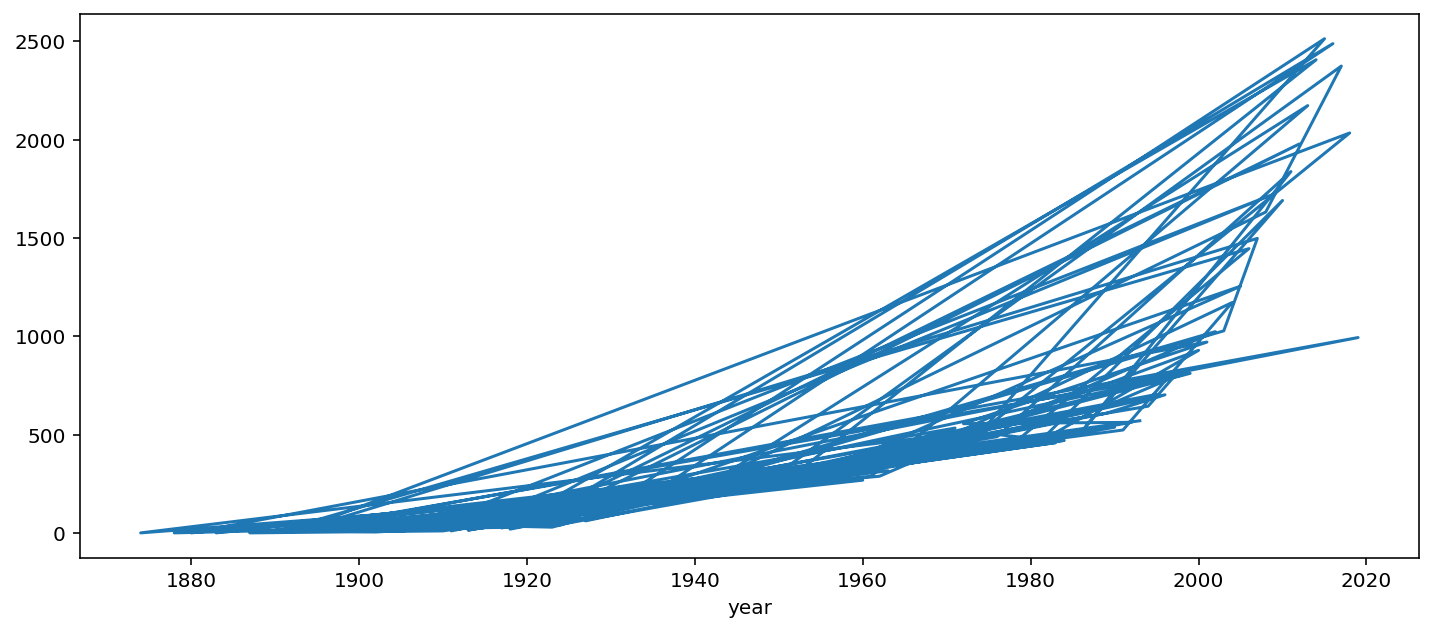

In [24]:
plt.figure(figsize=(12, 5))
relase_count_by_year.set_index('year')['count'].plot()
plt.show()

---
## Window Functions

Хотим понять, сколько времени проходит между последовательными оценками для пользователей, более формально:

Для пользователя $u$ есть последовательность $(m_1, r_1, t_1), \ldots, (m_n, r_n, t_n)$, где $t_i \leq t_{i+1}$. Рассмотрим последовательность $\Delta_i = t_{i+1} - t_i$, для $i=1,\ldots,n-1$.

Хотим построить распределение величины $\Delta_i$ используя информацию обо всех пользователях.

In [25]:
from pyspark.sql.window import Window


user_window = Window.orderBy('timestamp').partitionBy('user_id')

ratings_df \
    .withColumn('next_timestamp', F.lead('timestamp').over(user_window)) \
    .filter(F.col('next_timestamp').isNotNull()) \
    .take(10)

[Row(movie_id=2161, rating=3.5, timestamp=1280513623, user_id=26, next_timestamp=1280513649),
 Row(movie_id=455, rating=3.0, timestamp=1280513649, user_id=26, next_timestamp=1280513679),
 Row(movie_id=1037, rating=2.5, timestamp=1280513679, user_id=26, next_timestamp=1280513702),
 Row(movie_id=1586, rating=3.0, timestamp=1280513702, user_id=26, next_timestamp=1280513710),
 Row(movie_id=54286, rating=4.0, timestamp=1280513710, user_id=26, next_timestamp=1280513785),
 Row(movie_id=4023, rating=3.0, timestamp=1280513785, user_id=26, next_timestamp=1280513802),
 Row(movie_id=54503, rating=2.0, timestamp=1280513802, user_id=26, next_timestamp=1280513817),
 Row(movie_id=3173, rating=3.5, timestamp=1280513817, user_id=26, next_timestamp=1280513893),
 Row(movie_id=53322, rating=4.0, timestamp=1280513893, user_id=26, next_timestamp=1280513897),
 Row(movie_id=2764, rating=4.5, timestamp=1280513897, user_id=26, next_timestamp=1280513931)]

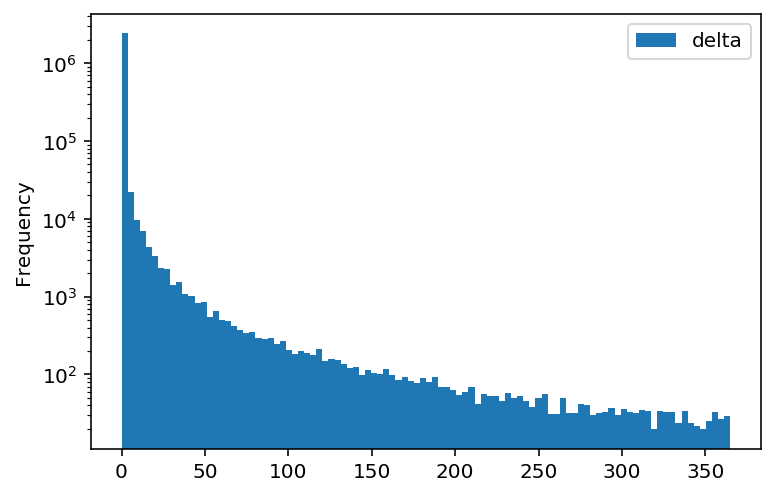

In [26]:
DAY = 24 * 60 * 60

ratings_df \
    .withColumn('next_timestamp', F.lead('timestamp').over(user_window)) \
    .filter(F.col('next_timestamp').isNotNull()) \
    .withColumn('delta', (F.col('next_timestamp') - F.col('timestamp')) / F.lit(DAY)) \
    .select('delta') \
    .filter(F.col('delta') <= 365) \
    .sample(False, 0.1) \
    .toPandas().plot.hist(bins=100, logy=True)

# Общие данные

In [27]:
movie_users = ratings_df \
    .select('movie_id', 'user_id')\
    .cache()

movie_counts = movie_users \
    .groupby('movie_id')\
    .agg(F.count('user_id').alias('user_count'))\
    .select('movie_id', 'user_count')\
    .cache()

user_counts = movie_users \
    .groupby('user_id')\
    .agg(F.count('movie_id').alias('movie_count'))\
    .select('user_id', 'movie_count')\
    .cache()

---
# Упражнения. Recommender System

Пусть $U$ - множество пользователей, $I$ - множество фильмов, и $R = (r_{ui})$ - матрица рейтингов. 

Через $R_u$ будем обозначать строку матрицы $R$, соотвествующую пользователю $u$.

## Most similar items

Для каждого фильма $i$ определим множество $U(i) = \{ u \in U \mid r_{ui} \neq 0 \}$ - множество пользователей, поставивших фильму $i$ оценку.

Тогда мы можем определить множество $I(i) = \left\{ i' \in I ~\Big|~ sim(i, i') = \frac{|U(i) ~\cap~ U(i')|}{|U(i) ~\cup~ U(i')|} > \delta \right\}$ - множество похожих фильмов.

Можно отсортировать элементы множества $I(i)$ по неубыванию $sim(i, i')$.

Реализуйте функцию, которая на вход получает `movie_id` и возвращает топ `N` фильмов отранжированных по $sim$.

In [28]:
def movies_by_user_intersection(target_user_groups, movie_users):
    target_counts = target_user_groups \
        .groupby('group_id')\
        .agg(F.count('user_id').alias('group_count'))\
        .select('group_id', 'group_count')
    
    user_intersection = movie_users \
        .join(target_user_groups, on='user_id', how='inner')\
        .groupby('group_id', 'movie_id')\
        .agg(F.count('user_id').alias('user_intersection'))\
        .select('group_id', 'movie_id', 'user_intersection')
    
    movie_sim = user_intersection \
        .join(movie_counts, on='movie_id', how='inner')\
        .join(target_counts, on='group_id', how='inner')\
        .withColumn('user_union', F.col('user_count') + F.col('group_count') - F.col('user_intersection'))\
        .withColumn('sim', F.col('user_intersection') / F.col('user_union'))\
        .select('group_id', 'movie_id', 'sim')

    return movie_sim

In [29]:
def similar_movies(movie_ids, movie_users, top_cnt=10, delta=0.1):
    if isinstance(movie_ids, int):
        movie_ids = [movie_ids]
    
    selected_movie_users = movie_users \
        .filter(F.col('movie_id').isin(*movie_ids))\
        .select('user_id', F.col('movie_id').alias('group_id'))
    
    movie_sim = movies_by_user_intersection(selected_movie_users, movie_users)

    movie_filtered_sim = movie_sim \
        .filter(F.col('sim') > delta)\
        .filter(~F.col('movie_id').isin(*movie_ids))\
        .groupby('movie_id')\
        .agg(F.max('sim').alias('sim'))\
        .select('movie_id', 'sim')

    movie_ranked_sim = movie_filtered_sim \
        .sort(F.col('sim').desc())\
    
    return movie_ranked_sim.limit(top_cnt)

In [30]:
similar_movies([356, 318, 296], movie_users) \
    .join(movies_df, F.col('movie_id') == movies_df.movieId, how='inner')\
    .select('movie_id', 'title', 'sim')\
    .sort(F.col('sim').desc())\
    .toPandas()

,movie_id,title,sim
0,593,"Silence of the Lambs, The (1991)",0.559290
1,480,Jurassic Park (1993),0.532613
2,47,Seven (a.k.a. Se7en) (1995),0.473053
3,50,"Usual Suspects, The (1995)",0.469513
4,527,Schindler's List (1993),0.466367
5,110,Braveheart (1995),0.464968
6,589,Terminator 2: Judgment Day (1991),0.447105
7,2571,"Matrix, The (1999)",0.445032
8,2959,Fight Club (1999),0.430660
9,457,"Fugitive, The (1993)",0.417657


In [31]:
similar_movies(356, movie_users) \
    .join(movies_df, F.col('movie_id') == movies_df.movieId, how='inner')\
    .select('movie_id', 'title', 'sim')\
    .sort(F.col('sim').desc())\
    .toPandas()

,movie_id,title,sim
0,480,Jurassic Park (1993),0.532613
1,296,Pulp Fiction (1994),0.517814
2,593,"Silence of the Lambs, The (1991)",0.506802
3,318,"Shawshank Redemption, The (1994)",0.502512
4,110,Braveheart (1995),0.464968
5,589,Terminator 2: Judgment Day (1991),0.447105
6,2571,"Matrix, The (1999)",0.434253
7,527,Schindler's List (1993),0.431358
8,457,"Fugitive, The (1993)",0.417657
9,150,Apollo 13 (1995),0.413883


In [32]:
similar_movies(318, movie_users) \
    .join(movies_df, F.col('movie_id') == movies_df.movieId, how='inner')\
    .select('movie_id', 'title', 'sim')\
    .sort(F.col('sim').desc())\
    .toPandas()

,movie_id,title,sim
0,296,Pulp Fiction (1994),0.531140
1,593,"Silence of the Lambs, The (1991)",0.507065
2,356,Forrest Gump (1994),0.502512
3,527,Schindler's List (1993),0.466367
4,50,"Usual Suspects, The (1995)",0.454932
5,2571,"Matrix, The (1999)",0.445032
6,110,Braveheart (1995),0.417833
7,2959,Fight Club (1999),0.412878
8,47,Seven (a.k.a. Se7en) (1995),0.403294
9,480,Jurassic Park (1993),0.388660


In [33]:
similar_movies(296, movie_users) \
    .join(movies_df, F.col('movie_id') == movies_df.movieId, how='inner')\
    .select('movie_id', 'title', 'sim')\
    .sort(F.col('sim').desc())\
    .toPandas()

,movie_id,title,sim
0,593,"Silence of the Lambs, The (1991)",0.559290
1,318,"Shawshank Redemption, The (1994)",0.531140
2,356,Forrest Gump (1994),0.517814
3,47,Seven (a.k.a. Se7en) (1995),0.473053
4,50,"Usual Suspects, The (1995)",0.469513
5,480,Jurassic Park (1993),0.446812
6,110,Braveheart (1995),0.438311
7,2959,Fight Club (1999),0.430660
8,589,Terminator 2: Judgment Day (1991),0.425699
9,2571,"Matrix, The (1999)",0.425180


In [34]:
similar_movies(364, movie_users) \
    .join(movies_df, F.col('movie_id') == movies_df.movieId, how='inner')\
    .select('movie_id', 'title', 'sim')\
    .sort(F.col('sim').desc())\
    .toPandas()

,movie_id,title,sim
0,588,Aladdin (1992),0.529844
1,595,Beauty and the Beast (1991),0.506798
2,500,Mrs. Doubtfire (1993),0.426725
3,480,Jurassic Park (1993),0.424750
4,367,"Mask, The (1994)",0.415767
5,377,Speed (1994),0.396942
6,356,Forrest Gump (1994),0.388577
7,344,Ace Ventura: Pet Detective (1994),0.381771
8,592,Batman (1989),0.377623
9,586,Home Alone (1990),0.375442


In [35]:
similar_movies(239, movie_users) \
    .join(movies_df, F.col('movie_id') == movies_df.movieId, how='inner')\
    .select('movie_id', 'title', 'sim')\
    .sort(F.col('sim').desc())\
    .toPandas()

,movie_id,title,sim
0,709,Oliver & Company (1988),0.192556
1,575,"Little Rascals, The (1994)",0.172711
2,1033,"Fox and the Hound, The (1981)",0.166446
3,2089,"Rescuers Down Under, The (1990)",0.162966
4,2123,All Dogs Go to Heaven (1989),0.156520
5,2142,"American Tail: Fievel Goes West, An (1991)",0.151786
6,13,Balto (1995),0.150260
7,1566,Hercules (1997),0.148062
8,2090,"Rescuers, The (1977)",0.147480
9,1015,Homeward Bound: The Incredible Journey (1993),0.145652


Построим несколько вариантов простой Рекомендательной Системы.

*Основная цель:* порекомендовать фильм пользователю. (Для простоты опустим информацию о самих рейтингах)

## Methods

При разработке сложных методов, сначала нужно выбрать несколько простотых методов (`Baseline`), относительно которых мы будем сравнивать новый метод.

### POP

Будем всегда рекомендовать самые популярные фильмы (с наибольшим цислом оценок пользователей).

Не смотря на свою простоту, в ряде задач показывает себя достаточно хорошо.

In [30]:
def pop(movie_users, top_cnt=10):
    movie_counts = movie_users \
        .groupby('movie_id')\
        .agg(F.count('user_id').alias('user_count'))
    
    ranked_movie_counts = movie_counts \
        .sort(F.col('user_count').desc())
    
    return ranked_movie_counts.limit(top_cnt)

In [37]:
pop(movie_users, top_cnt=20) \
    .join(movies_df, F.col('movie_id') == movies_df.movieId, how='inner')\
    .select('movie_id', 'title', 'user_count')\
    .sort(F.col('user_count').desc())\
    .toPandas()

,movie_id,title,user_count
0,356,Forrest Gump (1994),81491
1,318,"Shawshank Redemption, The (1994)",81482
2,296,Pulp Fiction (1994),79672
3,593,"Silence of the Lambs, The (1991)",74127
4,2571,"Matrix, The (1999)",72674
5,260,Star Wars: Episode IV - A New Hope (1977),68717
6,480,Jurassic Park (1993),64144
7,527,Schindler's List (1993),60411
8,110,Braveheart (1995),59184
9,2959,Fight Club (1999),58773


### User-based Collaborative Filtering

1. Для пользователя $u$ определим множество похожих пользователей как 

$$U(u) = \left\{ u' \in U \mid sim(u, u') > \alpha \right\},$$

где $sim(u, u')$ — одна из возможных мер близости $u'$ к $u$, например, косинусная близость между $R_{u}$ и $R_{u'}$

2. $$I(u) = \left\{ i \in I ~\Big|~ B(i) = \frac{|U(u) ~\cap~ U(i)|}{|U(u) ~\cup~ U(i)|} > 0 \right\}$$


3. Отсортировать $i \in I(u)$ по убыванию $B(i)$, взять top $N$

In [31]:
def ubcf(user_ids, movie_users, top_cnt=10, alpha=0.15, max_users=None):
    if isinstance(user_ids, int):
        user_ids = [user_ids]
    
    selected_user_movies = movie_users \
        .filter(F.col('user_id').isin(*user_ids))\
        .select('movie_id', F.col('user_id').alias('group_id'))

    selected_user_counts = selected_user_movies \
        .groupby('group_id')\
        .agg(F.count('movie_id').alias('group_count'))\
        .select('group_id', 'group_count')
    
    movie_intersection = movie_users \
        .join(selected_user_movies, on='movie_id', how='inner')\
        .groupby('user_id', 'group_id')\
        .agg(F.count('movie_id').alias('movie_intersection'))\
        .select('group_id', 'user_id', 'movie_intersection')
    
    similar_users = movie_intersection \
        .join(user_counts, on='user_id', how='inner')\
        .join(selected_user_counts, on='group_id', how='inner')\
        .withColumn('movie_union', F.col('movie_count') + F.col('group_count') - F.col('movie_intersection'))\
        .withColumn('sim', F.col('movie_intersection') / F.col('movie_union'))\
        .filter(F.col('sim') > alpha)\
        .select('group_id', 'user_id', 'sim')
    
    group_window = Window.orderBy(F.col('sim').desc()).partitionBy('group_id')
    
    if max_users is not None:
        similar_users = similar_users \
            .select('*', F.rank().over(group_window).alias('rank'))\
            .filter(F.col('rank') <= max_users)\
            .select('group_id', 'user_id')
    
    movie_sim = movies_by_user_intersection(similar_users, movie_users)
#     print(movie_sim.count(), selected_user_movies.count())
    
    movie_filtered_sim = movie_sim \
        .join(selected_user_movies, on=['movie_id', 'group_id'], how='left_anti')
#     print(movie_filtered_sim.count())
    
    movie_ranked_sim = movie_filtered_sim \
        .select('*', F.rank().over(group_window).alias('rank'))\
        .filter(F.col('rank') <= top_cnt)
    
    return movie_ranked_sim \
        .select(F.col('group_id').alias('target_user'), 'movie_id', 'sim')

In [39]:
%%time

ubcf([10, 11, 12, 13, 14], movie_users) \
    .join(movies_df, F.col('movie_id') == movies_df.movieId, how='inner')\
    .select('target_user', 'movie_id', 'title', 'sim')\
    .sort(F.col('sim').desc())\
    .toPandas()

CPU times: user 242 ms, sys: 113 ms, total: 355 ms
Wall time: 26.2 s


,target_user,movie_id,title,sim
0,12,2470,Crocodile Dundee (1986),0.314706
1,12,1377,Batman Returns (1992),0.300509
2,13,5218,Ice Age (2002),0.297808
3,12,1101,Top Gun (1986),0.296364
4,13,6373,Bruce Almighty (2003),0.292266
5,13,1682,"Truman Show, The (1998)",0.290145
6,13,48385,Borat: Cultural Learnings of America for Make ...,0.290103
7,13,4022,Cast Away (2000),0.289828
8,12,3052,Dogma (1999),0.288796
9,12,1573,Face/Off (1997),0.283989


In [40]:
%%time

ubcf(12, movie_users) \
    .join(movies_df, F.col('movie_id') == movies_df.movieId, how='inner')\
    .select('target_user', 'movie_id', 'title', 'sim')\
    .sort(F.col('sim').desc())\
    .toPandas()

CPU times: user 233 ms, sys: 63.3 ms, total: 296 ms
Wall time: 18.2 s


,target_user,movie_id,title,sim
0,12,2470,Crocodile Dundee (1986),0.314706
1,12,1377,Batman Returns (1992),0.300509
2,12,1101,Top Gun (1986),0.296364
3,12,3052,Dogma (1999),0.288796
4,12,1573,Face/Off (1997),0.283989
5,12,2890,Three Kings (1999),0.280075
6,12,2985,RoboCop (1987),0.273922
7,12,1608,Air Force One (1997),0.271547
8,12,2717,Ghostbusters II (1989),0.270652
9,12,1639,Chasing Amy (1997),0.270578


### Item-kNN

1. Для пользователя $u$ мы знаем $R(u) = \{ i \in I \mid r_{ui} \neq 0 \} $


2. Для каждого $i \in R(u)$ построим $I(i)$ - множество похожих фильмов


3. Отсортируем элементы множества $ \bigcup_{i \in R(u)} I(i) $, возьмем top $N$

In [32]:
def item_knn(user_id, movie_users, top_cnt=10, delta=0.15):
    selected_user_movies = movie_users \
        .filter(F.col('user_id') == user_id)\
        .select('movie_id')
    
    return similar_movies([int(row.movie_id) for row in selected_user_movies.collect()], 
                          ratings_df, top_cnt=top_cnt, delta=delta)

In [42]:
item_knn(12, movie_users) \
    .join(movies_df, F.col('movie_id') == movies_df.movieId, how='inner')\
    .select('movie_id', 'title', 'sim')\
    .sort(F.col('sim').desc())\
    .toPandas()

,movie_id,title,sim
0,5952,"Lord of the Rings: The Two Towers, The (2002)",0.765374
1,7153,"Lord of the Rings: The Return of the King, The...",0.740223
2,1198,Raiders of the Lost Ark (Indiana Jones and the...,0.575199
3,595,Beauty and the Beast (1991),0.573768
4,69844,Harry Potter and the Half-Blood Prince (2009),0.573138
5,153,Batman Forever (1995),0.563378
6,4886,"Monsters, Inc. (2001)",0.553000
7,589,Terminator 2: Judgment Day (1991),0.535215
8,2571,"Matrix, The (1999)",0.531374
9,8636,Spider-Man 2 (2004),0.512311


## Evaluation Protocol

Теперь опишем, как будем оценивать качество рассматриваемых методов.

### Data Splits

Так как в данных `ratings` есть поле `timestamp`, то для каждого пользователя отсортируем его рейтинги по времени и первые $80\%$ рейтингов отнесем в `Train`, еще $10\%$ в `Validation`, и остальное в `Test`.


In [33]:
TRAIN = 0.8
TEST = 0.1
VALIDATION = 1 - TRAIN - TEST

In [34]:
time_window = Window.orderBy('timestamp').partitionBy('user_id')

timed_ratings = ratings_df \
    .join(user_counts, on='user_id', how='inner')\
    .select('user_id', 'movie_id', F.rank().over(time_window).alias('rank'), 'movie_count')\
    .withColumn('rank_ratio', F.col('rank') / F.col('movie_count'))

train_ratings = timed_ratings \
    .filter(F.col('rank_ratio') < TRAIN)\
    .select('user_id', 'movie_id')
    
test_ratings = timed_ratings \
    .filter(F.col('rank_ratio') >= TRAIN)\
    .filter(F.col('rank_ratio') < TRAIN + TEST)\
    .select('user_id', 'movie_id')
    
valid_ratings = timed_ratings \
    .filter(F.col('rank_ratio') >= TRAIN + TEST)\
    .select('user_id', 'movie_id')

### Metrics

В `Test` для каждого пользователя есть `user_id, R_u`, где $R_u$ - множество фильмов, которым он поставил оценку. Для того чтобы оценить качество рассматриваемых методов будем для пользователя строить список из $N$ рекомендаций $\hat{R}_{1\colon N}$ и считать метрики.

* $$ Precision@N = \frac{|R_u \cap \hat{R}_{1\colon N} |}{N} $$
* $$ Recall@N = \frac{|R_u \cap \hat{R}_{1\colon N} |}{|R_u|} $$
* $Map@N$

где $N \in \{1,5,10\}$

https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html#ranking-systems

In [35]:
from collections import namedtuple

In [36]:
Metrics = namedtuple(
    'Metrics',
    ('precision', 'recall', 'MAP')
)

In [37]:
def compute_metrics(data, predictions, ns=[1, 5, 10]):
    metrics = []
    
    predictions = [int(p.movie_id) for p in predictions.collect()]
    print(data, predictions)
    
    def tp_at_k(k):
        return len([p for p in data if p in predictions[:k]])
    
    true_positives = [tp_at_k(k) for k in range(1, max(ns) + 1)]
    precisions = [tp / (k + 1)  for k, tp in enumerate(true_positives)]
    
    for n in ns:
        metrics.append(Metrics(
            precision=precisions[n - 1],
            recall=true_positives[n - 1] / len(data),
            MAP=np.mean(precisions[:n])
        ))

    return metrics

## Experimental Results

Посмотрим на результаты

*Remark* скорее всего посчитать метрики для всех пользователей будет довольно долго - можно ограничится, например, случайными 10к пользователями

In [38]:
baseline = pop(train_ratings, 10).cache()

In [39]:
users = [int(row.user_id) for row in movie_users.select('user_id').distinct().collect()]

In [42]:
subsample = np.random.choice(users, 1000).tolist()

In [44]:
baseline_metrics = []
ubcf_metrics = []
item_knn_metrics = []

for user in subsample:
    valid_data = [int(p.movie_id) for p in valid_ratings.filter(F.col('user_id') == user).collect()]
    if len(valid_data) == 0:
        continue
    baseline_metrics.append(compute_metrics(valid_data, baseline))
    print(baseline_metrics[-1])
    
    ubcf_metrics.append(compute_metrics(valid_data, ubcf(user, train_ratings)))
    print(ubcf_metrics[-1])
    
    item_knn_metrics.append(compute_metrics(valid_data, item_knn(user, train_ratings)))
    print(item_knn_metrics[-1])

[1676, 2840, 3176, 2672, 1624, 1721, 3163, 3082, 2170, 2424, 2006] [318, 356, 296, 593, 2571, 260, 480, 527, 110, 2959]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0)]
[1676, 2840, 3176, 2672, 1624, 1721, 3163, 3082, 2170, 2424, 2006] []
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0)]
[1676, 2840, 3176, 2672, 1624, 1721, 3163, 3082, 2170, 2424, 2006] [1196, 260, 2959, 4993, 7153, 5952, 780, 1198, 1291, 736]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0)]
[31696, 1250, 5956, 80463, 111759, 3948, 1240, 3986, 2334, 106920, 590, 8644, 84601, 91535, 1918] [318, 356, 296, 593, 2571, 260, 480, 527, 110, 2959]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, 

[111, 590, 515, 527, 592, 1221] [95, 36, 515, 62, 350, 161, 376, 14, 440, 348]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.2, recall=0.16666666666666666, MAP=0.15666666666666665), Metrics(precision=0.1, recall=0.16666666666666666, MAP=0.1428968253968254)]
[111, 590, 515, 527, 592, 1221] [1196, 1221, 592, 593, 356, 1198, 306, 587, 165, 377]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.4, recall=0.3333333333333333, MAP=0.4133333333333333), Metrics(precision=0.2, recall=0.3333333333333333, MAP=0.3357936507936508)]
[1428, 2324, 2834, 2686, 2700, 2671, 2718] [318, 356, 296, 593, 2571, 260, 480, 527, 110, 2959]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0)]
[1428, 2324, 2834, 2686, 2700, 2671, 2718] [1565, 398, 2198, 874, 2911, 297, 2695, 2330, 1519, 3728]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precisio

[33264, 4334, 5304, 6460, 4825, 49359, 89896, 5056, 26350, 2970, 50615, 7206, 26171, 773, 8188, 3645, 80, 47150, 31522, 8684, 8197, 2731, 81751, 1186, 45942, 1305, 30803, 1719, 1809, 49932, 1464, 5515, 78836, 112623, 104841, 51709, 1235, 32, 588, 344, 1580, 32792, 6896, 52927, 99917, 1419, 1199, 66097, 7766, 116897, 152081, 161582, 4754, 107771, 96829, 3677, 103984, 4881, 1080, 122882, 157296] [2731, 4914, 3683, 6787, 3681, 1245, 6001, 7766, 3468, 31410]
[Metrics(precision=1.0, recall=0.01639344262295082, MAP=1.0), Metrics(precision=0.2, recall=0.01639344262295082, MAP=0.45666666666666667), Metrics(precision=0.2, recall=0.03278688524590164, MAP=0.3265079365079365)]
[33264, 4334, 5304, 6460, 4825, 49359, 89896, 5056, 26350, 2970, 50615, 7206, 26171, 773, 8188, 3645, 80, 47150, 31522, 8684, 8197, 2731, 81751, 1186, 45942, 1305, 30803, 1719, 1809, 49932, 1464, 5515, 78836, 112623, 104841, 51709, 1235, 32, 588, 344, 1580, 32792, 6896, 52927, 99917, 1419, 1199, 66097, 7766, 116897, 152081, 

[32898, 63676, 73152, 32892, 44657, 6975, 2933, 1281, 3788, 2010, 26318, 8786, 8601, 8188, 48165, 26850, 2318] [96933, 96428, 81411, 45036, 49929, 95139, 68874, 81413, 80487, 73064]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0)]
[32898, 63676, 73152, 32892, 44657, 6975, 2933, 1281, 3788, 2010, 26318, 8786, 8601, 8188, 48165, 26850, 2318] [1196, 1291, 58559, 4993, 260, 7153, 5952, 1210, 2858, 4226]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0)]
[374, 661, 784, 271] [318, 356, 296, 593, 2571, 260, 480, 527, 110, 2959]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0)]
[374, 661, 784, 271] [153, 329, 454, 349, 434, 339, 292, 185, 161, 410]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), M

[103249, 53519, 111360, 104374, 5014, 107406, 34437, 7149, 112290, 5791] [318, 356, 296, 593, 2571, 260, 480, 527, 110, 2959]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0)]
[103249, 53519, 111360, 104374, 5014, 107406, 34437, 7149, 112290, 5791] [92259, 106782, 91529, 115713, 112556, 79132, 122882, 68157, 122904, 134853]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0)]
[103249, 53519, 111360, 104374, 5014, 107406, 34437, 7149, 112290, 5791] [1221, 593, 79132, 480, 2571, 6377, 4306, 53125, 106489, 47]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0)]
[151, 261, 293, 553, 272, 356] [318, 356, 296, 593, 2571, 260, 480, 527, 110, 2959]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.2, recall=0.16666666666666666, M

[1059, 52] [318, 356, 296, 593, 2571, 260, 480, 527, 110, 2959]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0)]
[1059, 52] [494, 79, 3, 786, 5, 140, 637, 805, 762, 52]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.1, recall=0.5, MAP=0.01)]
[1059, 52] [780, 736, 50, 296, 377, 593, 32, 1374, 1089, 786]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0)]
[1387, 2291, 72998, 1784, 288, 1393, 2355, 6365, 1584, 1721, 1580] [318, 356, 296, 593, 2571, 260, 480, 527, 110, 2959]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0)]
[1387, 2291, 72998, 1784, 288, 1393, 2355, 6365, 1584, 1721, 1580] [150, 153, 590, 500, 316, 10, 434, 454, 292, 527]
[Metrics(precision=0.0, recall=0.0, 

[50872, 8368, 68954, 4306, 59315, 364] [318, 356, 296, 593, 2571, 260, 480, 527, 110, 2959]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0)]
[50872, 8368, 68954, 4306, 59315, 364] [99114, 91529, 68954, 134130, 68157, 48516, 134853, 33794, 59315, 111759]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.2, recall=0.16666666666666666, MAP=0.15666666666666665), Metrics(precision=0.2, recall=0.3333333333333333, MAP=0.1640079365079365)]
[50872, 8368, 68954, 4306, 59315, 364] [1210, 1221, 6377, 480, 296, 4306, 68954, 593, 6539, 2115]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.2, recall=0.3333333333333333, MAP=0.11246031746031745)]
[1005, 1167, 1359, 1431, 1878, 1886, 2379, 420, 432, 435, 784, 829, 12, 87, 419, 429, 1126, 1461, 2152, 762, 818, 2381, 411, 1855, 2051, 2060, 1381, 1503, 1760, 2053, 2072] [318, 356, 296, 593, 25

[1944, 2571, 1196, 2080, 1201, 1303, 1947, 4011] [318, 356, 296, 593, 2571, 260, 480, 527, 110, 2959]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.2, recall=0.125, MAP=0.04), Metrics(precision=0.1, recall=0.125, MAP=0.08456349206349206)]
[1944, 2571, 1196, 2080, 1201, 1303, 1947, 4011] [3469, 3196, 615, 3619, 1945, 1267, 1178, 1283, 3467, 1939]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0)]
[1944, 2571, 1196, 2080, 1201, 1303, 1947, 4011] [1196, 1214, 858, 1291, 593, 356, 589, 1036, 2571, 47]
[Metrics(precision=1.0, recall=0.125, MAP=1.0), Metrics(precision=0.2, recall=0.125, MAP=0.45666666666666667), Metrics(precision=0.2, recall=0.25, MAP=0.3140079365079365)]
[110, 30749, 953, 48394] [318, 356, 296, 593, 2571, 260, 480, 527, 110, 2959]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.1, recall=0.25, MAP=0.021111111

[79134, 48322, 5047, 39444, 85131, 43679, 85342, 31225, 176101, 122896, 98203, 5433, 5833, 7454, 8368, 1321, 89190, 1, 4886, 1270, 61132, 2571, 3624, 3752, 4643, 4367, 3300] [122892, 102125, 122920, 106072, 106489, 94777, 103042, 86332, 117529, 91542]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0)]
[79134, 48322, 5047, 39444, 85131, 43679, 85342, 31225, 176101, 122896, 98203, 5433, 5833, 7454, 8368, 1321, 89190, 1, 4886, 1270, 61132, 2571, 3624, 3752, 4643, 4367, 3300] [1210, 81834, 1198, 69844, 8368, 4886, 40815, 2571, 106489, 4306]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.2, recall=0.037037037037037035, MAP=0.04), Metrics(precision=0.3, recall=0.1111111111111111, MAP=0.18273809523809523)]
[103253, 61323, 44665] [318, 356, 296, 593, 2571, 260, 480, 527, 110, 2959]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.

[234, 69, 5673, 5945, 6373, 293, 4967, 1136, 678, 1197, 2918, 1258, 7090, 1200, 6711, 1206, 6708, 1968, 5617, 101, 6881, 6440] [318, 356, 296, 593, 2571, 260, 480, 527, 110, 2959]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0)]
[234, 69, 5673, 5945, 6373, 293, 4967, 1136, 678, 1197, 2918, 1258, 7090, 1200, 6711, 1206, 6708, 1968, 5617, 101, 6881, 6440] [6711, 3996, 2706, 3481, 8622, 5349, 33166, 1917, 32587, 2918]
[Metrics(precision=1.0, recall=0.045454545454545456, MAP=1.0), Metrics(precision=0.2, recall=0.045454545454545456, MAP=0.45666666666666667), Metrics(precision=0.2, recall=0.09090909090909091, MAP=0.3028968253968254)]
[234, 69, 5673, 5945, 6373, 293, 4967, 1136, 678, 1197, 2918, 1258, 7090, 1200, 6711, 1206, 6708, 1968, 5617, 101, 6881, 6440] [1221, 8368, 6934, 593, 8665, 231, 589, 4993, 588, 597]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Met

Py4JJavaError: An error occurred while calling o66057.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 156 in stage 6202.0 failed 1 times, most recent failure: Lost task 156.0 in stage 6202.0 (TID 711970, localhost, executor driver): java.io.IOException: No space left on device
	at java.io.FileOutputStream.writeBytes(Native Method)
	at java.io.FileOutputStream.write(FileOutputStream.java:326)
	at org.apache.spark.storage.TimeTrackingOutputStream.write(TimeTrackingOutputStream.java:58)
	at java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:82)
	at java.io.BufferedOutputStream.flush(BufferedOutputStream.java:140)
	at net.jpountz.lz4.LZ4BlockOutputStream.finish(LZ4BlockOutputStream.java:260)
	at net.jpountz.lz4.LZ4BlockOutputStream.close(LZ4BlockOutputStream.java:190)
	at java.io.FilterOutputStream.close(FilterOutputStream.java:159)
	at java.io.FilterOutputStream.close(FilterOutputStream.java:159)
	at org.apache.spark.sql.execution.UnsafeRowSerializerInstance$$anon$1.close(UnsafeRowSerializer.scala:96)
	at org.apache.spark.storage.DiskBlockObjectWriter.commitAndGet(DiskBlockObjectWriter.scala:173)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:156)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD$$anonfun$reduce$1.apply(RDD.scala:1080)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:1062)
	at org.apache.spark.rdd.RDD$$anonfun$takeOrdered$1.apply(RDD.scala:1484)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.RDD.takeOrdered(RDD.scala:1471)
	at org.apache.spark.sql.execution.TakeOrderedAndProjectExec.executeCollect(limit.scala:136)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3263)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3260)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:80)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:127)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:75)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3260)
	at sun.reflect.GeneratedMethodAccessor114.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.IOException: No space left on device
	at java.io.FileOutputStream.writeBytes(Native Method)
	at java.io.FileOutputStream.write(FileOutputStream.java:326)
	at org.apache.spark.storage.TimeTrackingOutputStream.write(TimeTrackingOutputStream.java:58)
	at java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:82)
	at java.io.BufferedOutputStream.flush(BufferedOutputStream.java:140)
	at net.jpountz.lz4.LZ4BlockOutputStream.finish(LZ4BlockOutputStream.java:260)
	at net.jpountz.lz4.LZ4BlockOutputStream.close(LZ4BlockOutputStream.java:190)
	at java.io.FilterOutputStream.close(FilterOutputStream.java:159)
	at java.io.FilterOutputStream.close(FilterOutputStream.java:159)
	at org.apache.spark.sql.execution.UnsafeRowSerializerInstance$$anon$1.close(UnsafeRowSerializer.scala:96)
	at org.apache.spark.storage.DiskBlockObjectWriter.commitAndGet(DiskBlockObjectWriter.scala:173)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:156)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [62]:
user = subsample[89]
valid_data = [int(p.movie_id) for p in valid_ratings.filter(F.col('user_id') == user).collect()]
item_knn_metrics.append(compute_metrics(valid_data, item_knn(user, train_ratings)))

[234, 69, 5673, 5945, 6373, 293, 4967, 1136, 678, 1197, 2918, 1258, 7090, 1200, 6711, 1206, 6708, 1968, 5617, 101, 6881, 6440] [1221, 8368, 6934, 593, 8665, 231, 589, 4993, 588, 597]


In [60]:
for user in subsample[90:100]:
    valid_data = [int(p.movie_id) for p in valid_ratings.filter(F.col('user_id') == user).collect()]
    if len(valid_data) == 0:
        continue
    baseline_metrics.append(compute_metrics(valid_data, baseline))
    print(baseline_metrics[-1])
    
    ubcf_metrics.append(compute_metrics(valid_data, ubcf(user, train_ratings)))
    print(ubcf_metrics[-1])
    
    item_knn_metrics.append(compute_metrics(valid_data, item_knn(user, train_ratings)))
    print(item_knn_metrics[-1])

[1028, 516, 304, 377, 64, 358, 1010, 239, 378, 1012, 435, 227, 529, 548, 9, 299, 464] [318, 356, 296, 593, 2571, 260, 480, 527, 110, 2959]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.0, recall=0.0, MAP=0.0)]
[1028, 516, 304, 377, 64, 358, 1010, 239, 378, 1012, 435, 227, 529, 548, 9, 299, 464] [349, 590, 288, 160, 377, 435, 480, 509, 337, 235]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.2, recall=0.058823529411764705, MAP=0.04), Metrics(precision=0.2, recall=0.11764705882352941, MAP=0.1491269841269841)]
[1028, 516, 304, 377, 64, 358, 1010, 239, 378, 1012, 435, 227, 529, 548, 9, 299, 464] [480, 590, 648, 377, 1240, 527, 349, 2571, 736, 2959]
[Metrics(precision=0.0, recall=0.0, MAP=0.0), Metrics(precision=0.2, recall=0.058823529411764705, MAP=0.09), Metrics(precision=0.1, recall=0.058823529411764705, MAP=0.10956349206349207)]
[421, 1036, 1020, 158, 455, 480] [318, 356, 296, 593, 2571, 260, 480, 527, 1

In [63]:
len(baseline_metrics), len(ubcf_metrics), len(item_knn_metrics)

(100, 100, 100)

In [64]:
def print_stats(metrics_list):
    for i, n in enumerate([1, 5, 10]):
        print(f'Precision@{n}')
        print(f'{np.mean([m[i].precision for m in metrics_list]):.4f}+-{np.std([m[i].precision for m in metrics_list]):.4f}')
    print()
    for i, n in enumerate([1, 5, 10]):
        print(f'Recall@{n}')
        print(f'{np.mean([m[i].recall for m in metrics_list]):.4f}+-{np.std([m[i].recall for m in metrics_list]):.4f}')
    print()
    for i, n in enumerate([1, 5, 10]):
        print(f'MAP@{n}')
        print(f'{np.mean([m[i].MAP for m in metrics_list]):.4f}+-{np.std([m[i].MAP for m in metrics_list]):.4f}')
    print()

In [65]:
print('Baseline (most popular):')
print()
print_stats(baseline_metrics)

Baseline (most popular):

Precision@1
0.0300+-0.1706
Precision@5
0.0300+-0.0954
Precision@10
0.0240+-0.0585

Recall@1
0.0044+-0.0266
Recall@5
0.0187+-0.0637
Recall@10
0.0313+-0.0806

MAP@1
0.0300+-0.1706
MAP@5
0.0332+-0.1243
MAP@10
0.0293+-0.0934



In [66]:
print('User-based collaborative filtering:')
print()
print_stats(ubcf_metrics)

User-based collaborative filtering:

Precision@1
0.0400+-0.1960
Precision@5
0.0360+-0.0819
Precision@10
0.0360+-0.0714

Recall@1
0.0031+-0.0190
Recall@5
0.0216+-0.0659
Recall@10
0.0413+-0.0966

MAP@1
0.0400+-0.1960
MAP@5
0.0384+-0.1048
MAP@10
0.0374+-0.0843



In [67]:
print('Item-knn:')
print()
print_stats(item_knn_metrics)

Item-knn:

Precision@1
0.0600+-0.2375
Precision@5
0.0640+-0.1162
Precision@10
0.0610+-0.0915

Recall@1
0.0062+-0.0307
Recall@5
0.0385+-0.0991
Recall@10
0.0667+-0.1200

MAP@1
0.0600+-0.2375
MAP@5
0.0655+-0.1365
MAP@10
0.0663+-0.1089

